# Cifar10 dataset

# Import the packages

In [1]:
import torch
import torchvision

# Setup
# Preprocessing

In [2]:
from torchvision.transforms import Compose, ToTensor, Normalize

# Define a transform to normalize the data
transform: Compose = Compose([
    # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    ToTensor(),
    
    # Normalize a tensor image with mean and standard deviation.
    # output[channel] = (input[channel] - mean[channel]) / std[channel] -> normalised = (original - 0.5) / 0.5]
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

## Load the dataset

In [3]:
from torch import Tensor
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10

# load the full CIFAR-10 training data
full_trainset: CIFAR10 = CIFAR10(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

# split the full training data into train and validation sets
train_size: int = int(0.8 * len(full_trainset))
valid_size: int = len(full_trainset) - train_size

# TODO: check annotation type, and understand the function
trainset, validset = random_split(full_trainset, [train_size, valid_size])

# load the test data
testset: CIFAR10 = CIFAR10(
    root='../data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# print dataset sizes
print(f"All samples: {len(trainset)+len(validset)+len(testset)}")
print(f"Train samples: {len(trainset)}")
print(f"Validation samples: {len(validset)}")
print(f"Test samples: {len(testset)}")

# get one sample to check image shape
image, label = full_trainset[0]
print(f"Single image shape: {image.shape}")

All samples: 60000
Train samples: 40000
Validation samples: 10000
Test samples: 10000
Single image shape: torch.Size([3, 32, 32])


## Create data loaders

In [5]:
from torch.utils.data import DataLoader

trainloader: DataLoader = DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)
# 
# validloader = torch.utils.data.DataLoader(
validloader: DataLoader = DataLoader(
    validset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

testloader: DataLoader = DataLoader(
    testset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# Check shapes
xb, yb = next(iter(trainloader))
print("Batch shape:", xb.shape)   # should be [B, 3, 32, 32]

Batch shape: torch.Size([64, 3, 32, 32])


## View a batch of images

Shape before transpose: (3, 274, 274)
Shape after transpose: (274, 274, 3)


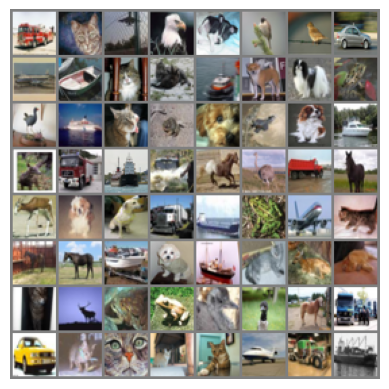

In [6]:

import matplotlib.pyplot as plt
import numpy as np

# Helper function to display an image grid
def show_image(image_tensor: torch.Tensor) -> None:
    """Convert a PyTorch tensor into a viewable image grid and show it."""

    # Step 1 Undo normalization: normalised = (original - 0.5) / 0.5] -> normalised * 2 +0.5 = original
    unnormalized_image_grid = image_tensor * 0.5 + 0.5

    # Step 2: Convert from a PyTorch tensor to a NumPy array (for matplotlib)
    # .detach() removes gradient tracking; .cpu() ensures data is on the CPU.
    image_grid_C_H_W = unnormalized_image_grid.detach().cpu().numpy()
    
    print("Shape before transpose:", image_grid_C_H_W.shape)  
    # (C, H, W) → C = number of color channels (3 for RGB), H = height, W = width

    # Step 3: Rearrange dimensions from (C, H, W) to (H, W, C)
    # because Matplotlib expects the color channel as the last dimension.
    image_grid_H_W_C = np.transpose(image_grid_C_H_W, (1, 2, 0))
    print("Shape after transpose:", image_grid_H_W_C.shape)   # (H, W, C)

    # Step 4: Display the image
    plt.imshow(image_grid_H_W_C)
    plt.axis("off")  # hide axis numbers
    plt.show()
    
# Get a batch of training images
data_iter: iter = iter(trainloader)  # Create an iterator for the DataLoader
images: torch.Tensor
labels: torch.Tensor
images, labels = next(data_iter)   # Get one batch (images + labels)

# Make a grid from the batch
image_grid: torch.Tensor = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row


# Show the grid
show_image(image_grid)


## Get class labels

In [7]:
# TODO: Get the label directly cifar10_classes = cifar10.classes

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(classes[labels[0]])  


truck


# Variational autoencoder

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# ===== Autoencoder, training loop, and visualization =====
from typing import Tuple
from torch import nn
import torch.optim as optim
import torchvision


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class ConvAutoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Encoder: 32x32 -> 16x16 -> 8x8 (latent 128ch)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 3x32x32 -> 32x16x16
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 32x16x16 -> 64x8x8
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# 64x8x8 -> 128x8x8
            nn.ReLU(inplace=True),
        )
        # Decoder: 8x8 -> 16x16 -> 32x32, output in [-1, 1] via Tanh
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),      # 128x8x8 -> 64x8x8
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),       # 64x8x8 -> 32x16x16
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),        # 32x16x16 -> 3x32x32
            nn.Tanh(),  # because inputs are normalized to [-1, 1]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

def run_epoch(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    optimizer: optim.Optimizer | None,
) -> Tuple[float, int]:
    """
    If optimizer is None -> eval mode; otherwise train mode.
    Returns (sum_loss, num_samples).
    """
    is_train = optimizer is not None
    model.train(is_train)
    total_loss = 0.0
    n = 0

    for xb, _ in loader:  # labels are unused for autoencoders
        xb = xb.to(device, non_blocking=True)
        if is_train:
            optimizer.zero_grad(set_to_none=True)
        xhat = model(xb)
        loss = criterion(xhat, xb)  # reconstruct normalized input
        if is_train:
            loss.backward()
            optimizer.step()

        bs = xb.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss, n


# ---- Train ----
train_hist = []
val_hist = []
epochs = 10
best_val = float("inf")
for epoch in range(1, epochs + 1):
    train_loss_sum, train_n = run_epoch(model, trainloader, optimizer)
    val_loss_sum, val_n = run_epoch(model, validloader, optimizer=None)

    train_loss = train_loss_sum / train_n
    val_loss   = val_loss_sum / val_n

    train_hist.append(train_loss)
    val_hist.append(val_loss)

    print(f"Epoch {epoch:02d}/{epochs} | train MSE: {train_loss:.5f} | val MSE: {val_loss:.5f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "conv_autoencoder_cifar10.pt")
        print("  ↳ Saved new best model.")

Using device: cuda
Epoch 01/10 | train MSE: 0.02795 | val MSE: 0.01043
  ↳ Saved new best model.
Epoch 02/10 | train MSE: 0.00830 | val MSE: 0.00637
  ↳ Saved new best model.
Epoch 03/10 | train MSE: 0.00573 | val MSE: 0.00480
  ↳ Saved new best model.
Epoch 04/10 | train MSE: 0.00471 | val MSE: 0.00513
Epoch 05/10 | train MSE: 0.00392 | val MSE: 0.00516
Epoch 06/10 | train MSE: 0.00350 | val MSE: 0.00640
Epoch 07/10 | train MSE: 0.00307 | val MSE: 0.00261
  ↳ Saved new best model.
Epoch 08/10 | train MSE: 0.00276 | val MSE: 0.00233
  ↳ Saved new best model.
Epoch 09/10 | train MSE: 0.00246 | val MSE: 0.00209
  ↳ Saved new best model.
Epoch 10/10 | train MSE: 0.00248 | val MSE: 0.00195
  ↳ Saved new best model.


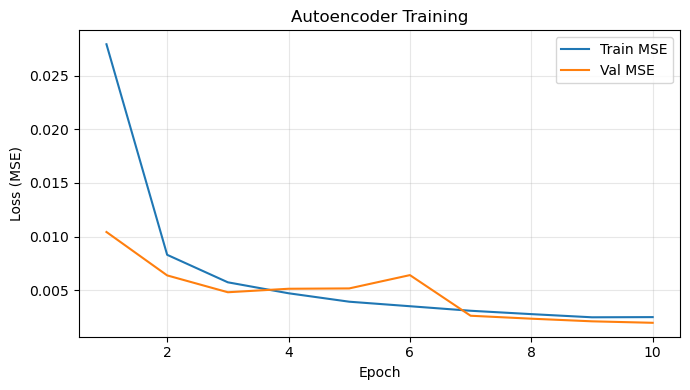

In [10]:
import matplotlib.pyplot as plt
import numpy as np

epochs_axis = np.arange(1, len(train_hist) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs_axis, train_hist, label="Train MSE")
plt.plot(epochs_axis, val_hist, label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Autoencoder Training")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Originals:
Shape before transpose: (3, 138, 274)
Shape after transpose: (138, 274, 3)


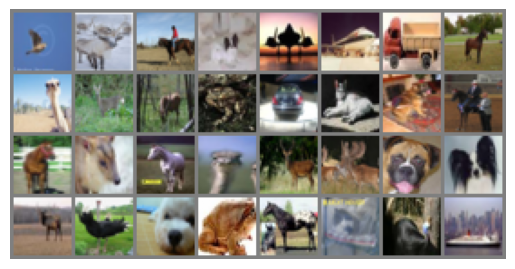

Reconstructions:
Shape before transpose: (3, 138, 274)
Shape after transpose: (138, 274, 3)


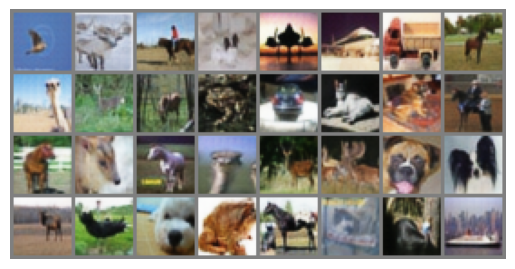

Test MSE: 0.00196


In [11]:
# ---- Quick reconstruction preview ----
model.eval()
with torch.inference_mode():
    xb, _ = next(iter(validloader))
    xb = xb.to(device)
    xhat = model(xb)
    # make grids for originals and reconstructions (same normalization [-1,1])
    grid_orig = torchvision.utils.make_grid(xb[:32].cpu(), nrow=8)   # 4 rows
    grid_reco = torchvision.utils.make_grid(xhat[:32].cpu(), nrow=8)
    print("Originals:")
    show_image(grid_orig)
    print("Reconstructions:")
    show_image(grid_reco)

# (Optional) compute a simple test MSE
test_loss_sum, test_n = run_epoch(model, testloader, optimizer=None)
print(f"Test MSE: {test_loss_sum / test_n:.5f}")

# Exploration of the latent represenation (umap)

/storage/homefs/ae04q066/.conda/envs/py3.10/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


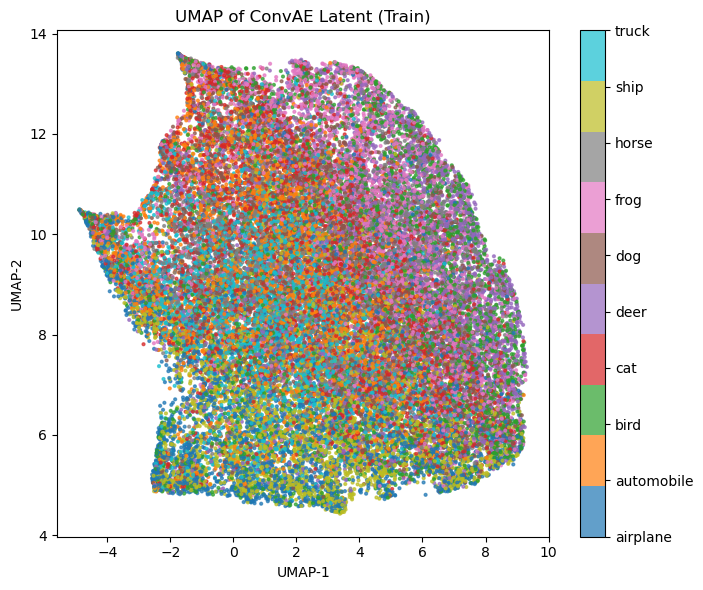

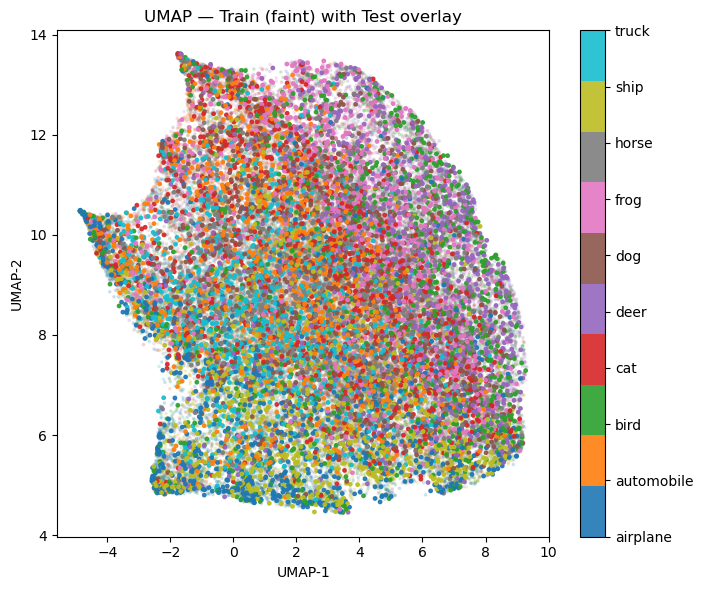

In [12]:

# ===== Step 2: Explore the latent representation (UMAP) =====
# Collect latent vectors from your trained ConvAutoencoder and visualize with UMAP
# Requires: pip install umap-learn scikit-learn

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# CIFAR-10 class names for nicer legends
CIFAR10_NAMES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

@torch.inference_mode()
def collect_latents(dataloader, model, device, method: str = "gap"):
    """
    Extract a fixed-length latent vector per image from the encoder.
    method:
      - 'gap': Global Average Pooling over the 8x8 feature map -> (B, 128)
      - 'flatten': Flatten the full 8x8 map -> (B, 8192)
    Returns: (Z: np.ndarray [N, D], y: np.ndarray [N])
    """
    zs, ys = [], []
    model.eval()
    for xb, yb in dataloader:
        xb = xb.to(device, non_blocking=True)
        feats = model.encoder(xb)                # (B, 128, 8, 8)
        if method == "gap":
            z = F.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)  # (B, 128)
        elif method == "flatten":
            z = feats.flatten(1)                 # (B, 8192)
        else:
            raise ValueError("method must be 'gap' or 'flatten'")
        zs.append(z.cpu().numpy())
        ys.append(yb.numpy())
    Z = np.concatenate(zs, axis=0)
    y = np.concatenate(ys, axis=0)
    return Z, y

# --- 1) Encode to latent vectors (use training set to fit UMAP) ---
Z_train, y_train = collect_latents(trainloader, model, device, method="gap")
Z_val,   y_val   = collect_latents(validloader, model, device, method="gap")
Z_test,  y_test  = collect_latents(testloader,  model, device, method="gap")

# --- 2) Standardize latent features (important for UMAP stability) ---
scaler = StandardScaler().fit(Z_train)
Ztr = scaler.transform(Z_train)
Zva = scaler.transform(Z_val)
Zte = scaler.transform(Z_test)

# --- 3) Fit UMAP on train; transform val/test for fair comparison ---
umap2d = UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric="euclidean", random_state=0)
Utr = umap2d.fit_transform(Ztr)
Uva = umap2d.transform(Zva)
Ute = umap2d.transform(Zte)

# --- 4) Plot: Train UMAP colored by class ---
plt.figure(figsize=(7.2, 6))
sc = plt.scatter(Utr[:, 0], Utr[:, 1], c=y_train, s=4, alpha=0.7, cmap="tab10")
cbar = plt.colorbar(sc, ticks=range(10))
cbar.ax.set_yticklabels(CIFAR10_NAMES)
plt.title("UMAP of ConvAE Latent (Train)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.tight_layout()
plt.show()

# (Optional) Overlay validation/test to see generalization
plt.figure(figsize=(7.2, 6))
plt.scatter(Utr[:, 0], Utr[:, 1], c=y_train, s=3, alpha=0.15, cmap="tab10")  # background
sc2 = plt.scatter(Ute[:, 0], Ute[:, 1], c=y_test, s=6, alpha=0.9, cmap="tab10")
cbar = plt.colorbar(sc2, ticks=range(10))
cbar.ax.set_yticklabels(CIFAR10_NAMES)
plt.title("UMAP — Train (faint) with Test overlay")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.tight_layout()
plt.show()



Overall structure

* The map shows a continuous, dense cloud rather than distinct clusters.

* That’s expected — your autoencoder is trained unsupervised only to reconstruct images, not to separate classes.

* Therefore, latent codes mainly capture visual similarity (colors, textures, shapes) rather than semantic categories.

# Find outliers
test 

Flagged 400 outliers (1.0%).


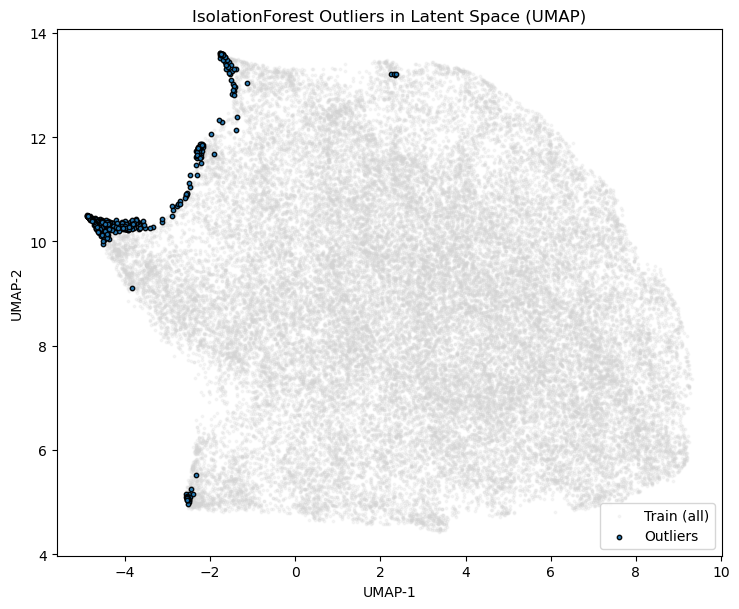

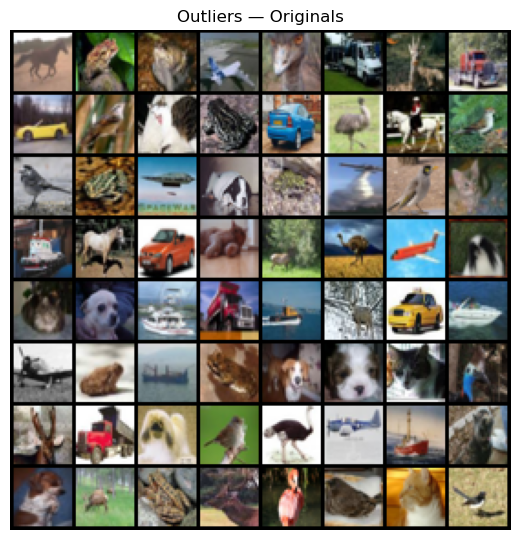

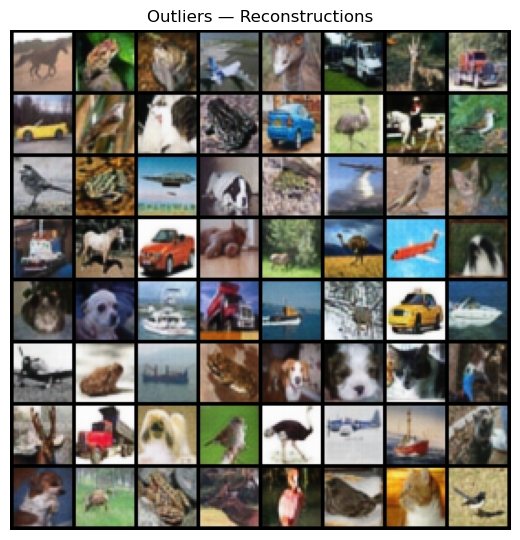

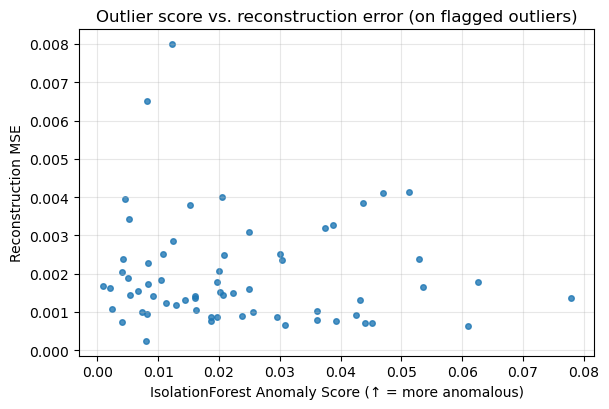

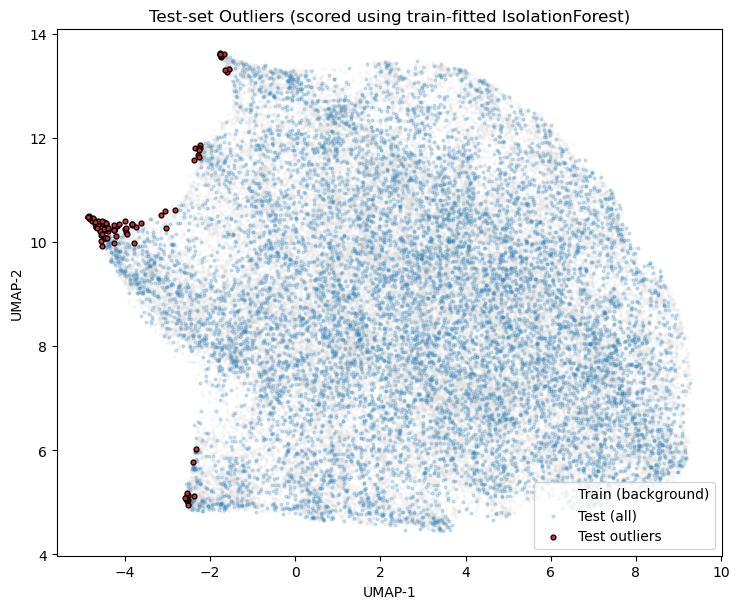

In [13]:
# ===== Step 3: Identify outliers in latent space =====
# We'll score anomalies with IsolationForest on the *standardized latent vectors* (Ztr).
# Then we (a) highlight them on the UMAP map and (b) visualize the corresponding images.

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from torchvision.utils import make_grid

# --- 1) Fit IsolationForest on train latents (standardized) ---
# Assumes you already have: Z_train, y_train, scaler, Ztr (scaled), Utr (UMAP 2D), trainloader, model, device
contamination = 0.01  # top 1% most anomalous
iso = IsolationForest(n_estimators=400, contamination=contamination, random_state=0)
iso.fit(Ztr)

# Anomaly score: higher = more anomalous
scores_train = -iso.decision_function(Ztr)
thr = np.quantile(scores_train, 1.0 - contamination)
out_idx = np.where(scores_train >= thr)[0]
print(f"Flagged {len(out_idx)} outliers ({contamination*100:.1f}%).")

# --- 2) Visualize outliers on UMAP (train) ---
plt.figure(figsize=(7.5, 6.2))
plt.scatter(Utr[:, 0], Utr[:, 1], c="lightgray", s=3, alpha=0.20, label="Train (all)")
plt.scatter(Utr[out_idx, 0], Utr[out_idx, 1], s=10, alpha=0.95, edgecolor="k", label="Outliers")
plt.title("IsolationForest Outliers in Latent Space (UMAP)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(loc="lower right")
plt.tight_layout(); plt.show()

# --- 3) Inspect a batch of outlier images (originals + reconstructions) ---
def to_vis(x):
    # inputs are in [-1, 1]; map to [0,1] for display
    return (x.clamp(-1, 1) + 1) / 2

# Take up to 64 outliers for quick inspection
k = min(64, len(out_idx))
sel = out_idx[:k]

# Collect images from the underlying dataset
train_ds = trainloader.dataset
imgs = torch.stack([train_ds[i][0] for i in sel], 0)  # shape: (k, 3, 32, 32)

# Reconstructions
model.eval()
with torch.inference_mode():
    x = imgs.to(device)
    xhat = model(x).cpu()

grid_orig = make_grid(to_vis(imgs), nrow=8, padding=2)
grid_reco = make_grid(to_vis(xhat), nrow=8, padding=2)

plt.figure(figsize=(6.5, 6.5))
plt.axis("off")
plt.title("Outliers — Originals")
plt.imshow(grid_orig.permute(1, 2, 0))
plt.show()

plt.figure(figsize=(6.5, 6.5))
plt.axis("off")
plt.title("Outliers — Reconstructions")
plt.imshow(grid_reco.permute(1, 2, 0))
plt.show()

# --- 4) (Optional) Compare anomaly score vs. reconstruction error ---
# This helps separate "data oddities" (high anomaly, possibly also high recon error) from
# "distribution-edge but well reconstructed" images.
import torch.nn.functional as F

with torch.inference_mode():
    # compute per-sample MSE on the same selected outliers for illustration
    x = imgs.to(device); xhat = model(x)
    rec_err = F.mse_loss(xhat, x, reduction="none").mean(dim=(1,2,3)).cpu().numpy()

plt.figure(figsize=(6.2, 4.2))
plt.scatter(scores_train[sel], rec_err, s=16, alpha=0.8)
plt.xlabel("IsolationForest Anomaly Score (↑ = more anomalous)")
plt.ylabel("Reconstruction MSE")
plt.title("Outlier score vs. reconstruction error (on flagged outliers)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# --- 5) (Optional) Run the detector on test latents to flag unusual test samples too ---
# Assumes you already computed Z_test -> Zte (scaled) and Ute (UMAP)
scores_test = -iso.decision_function(Zte)
thr_test = np.quantile(scores_test, 1.0 - contamination)
out_idx_test = np.where(scores_test >= thr_test)[0]

plt.figure(figsize=(7.5, 6.2))
plt.scatter(Utr[:, 0], Utr[:, 1], c="lightgray", s=3, alpha=0.12, label="Train (background)")
plt.scatter(Ute[:, 0], Ute[:, 1], c="tab:blue", s=4, alpha=0.20, label="Test (all)")
plt.scatter(Ute[out_idx_test, 0], Ute[out_idx_test, 1], c="tab:red", s=12, alpha=0.95, edgecolor="k", label="Test outliers")
plt.title("Test-set Outliers (scored using train-fitted IsolationForest)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(loc="lower right")
plt.tight_layout(); plt.show()


# Sample from the latent distribution

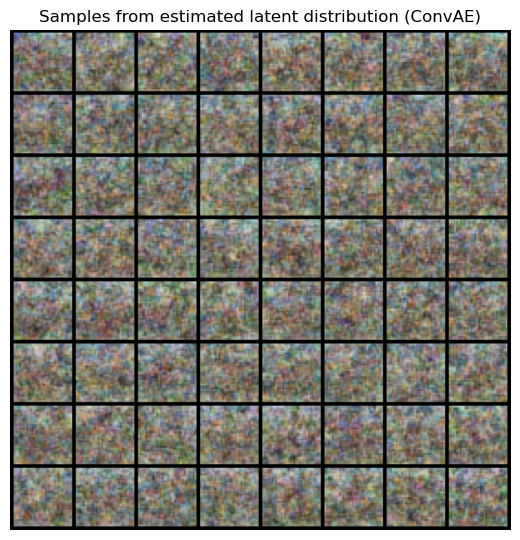

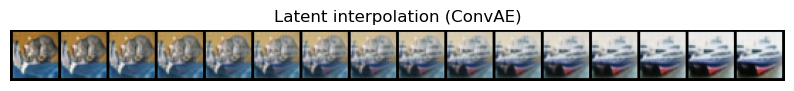

In [14]:
# ===== Step 4: Sample from the latent distribution (for your ConvAutoencoder) =====
# Since this is a *plain autoencoder* (not a VAE), there is no explicit N(0, I) prior.
# We approximate the latent distribution by estimating a *per-feature Gaussian* over the
# encoder's latent tensor (shape: 128×8×8), then sample from that and decode.

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

@torch.inference_mode()
def estimate_latent_stats(model, loader, device):
    """
    Estimate per-feature mean and std of encoder outputs across the training set.
    Uses a numerically-stable, batched aggregation (no need to store all latents).
    Returns mean, std with shape (C, H, W) == (128, 8, 8).
    """
    model.eval()
    count = 0
    mean = None
    M2 = None  # sum of squares of differences from the current mean

    for xb, _ in loader:
        xb = xb.to(device, non_blocking=True)
        z_b = model.encoder(xb).cpu()  # (B, 128, 8, 8)

        b = z_b.shape[0]
        batch_mean = z_b.mean(dim=0)                 # (128, 8, 8)
        batch_var  = z_b.var(dim=0, unbiased=False)  # (128, 8, 8)

        if mean is None:
            mean = batch_mean.clone()
            M2   = batch_var * b
            count = b
        else:
            new_count = count + b
            delta = batch_mean - mean
            mean = mean + delta * (b / new_count)
            # parallel variance update
            M2 = M2 + batch_var * b + (delta**2) * (count * b / new_count)
            count = new_count

    var = M2 / max(count - 1, 1)  # unbiased estimate
    std = torch.sqrt(var + 1e-8)
    return mean, std

def to_vis(x):
    # map [-1, 1] -> [0, 1] for display
    return (x.clamp(-1, 1) + 1) / 2

# --- 1) Fit a diagonal Gaussian to the latent tensor using the *training* set ---
mu_lat, std_lat = estimate_latent_stats(model, trainloader, device)  # (128, 8, 8)

# --- 2) Sample latent tensors and decode ---
model.eval()
num_samples = 64
temperature = 1.0  # < 1.0 = sharper/safer, > 1.0 = more diverse but riskier

with torch.inference_mode():
    eps = torch.randn(num_samples, *mu_lat.shape)              # (B, 128, 8, 8)
    z_samples = mu_lat.unsqueeze(0) + temperature * std_lat.unsqueeze(0) * eps
    x_gen = model.decoder(z_samples.to(device)).cpu()          # decoded RGB in [-1, 1]

# --- 3) Visualize the generated samples ---
grid_gen = make_grid(to_vis(x_gen), nrow=8, padding=2)
plt.figure(figsize=(6.5, 6.5))
plt.axis("off"); plt.title("Samples from estimated latent distribution (ConvAE)")
plt.imshow(grid_gen.permute(1, 2, 0)); plt.show()

# --- (Optional) Interpolation in latent space for smoothness check ---
# Pick two random training images, encode, and interpolate between their latents.
@torch.inference_mode()
def latent_interpolation(model, loader, device, steps=8):
    xb, _ = next(iter(loader))
    a, b = xb[0:1].to(device), xb[1:2].to(device)
    za = model.encoder(a)  # (1, 128, 8, 8)
    zb = model.encoder(b)
    alphas = torch.linspace(0, 1, steps).view(-1, 1, 1, 1).to(device)
    z_path = (1 - alphas) * za + alphas * zb
    x_path = model.decoder(z_path).cpu()
    return x_path

x_interp = latent_interpolation(model, testloader, device, steps=16)
grid_interp = make_grid(to_vis(x_interp), nrow=16, padding=2)
plt.figure(figsize=(10, 2.8))
plt.axis("off"); plt.title("Latent interpolation (ConvAE)")
plt.imshow(grid_interp.permute(1, 2, 0)); plt.show()


# overlay with data points
What does it mean?

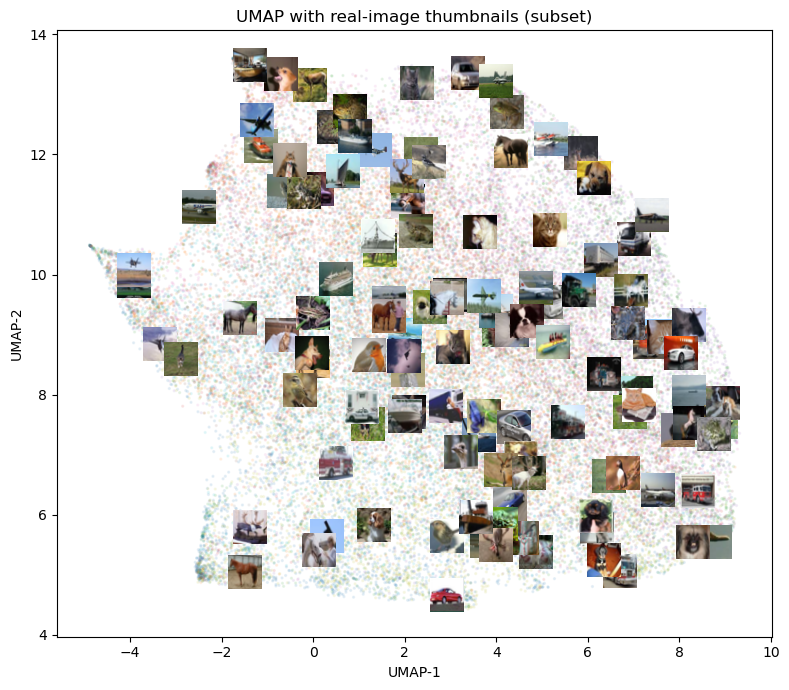

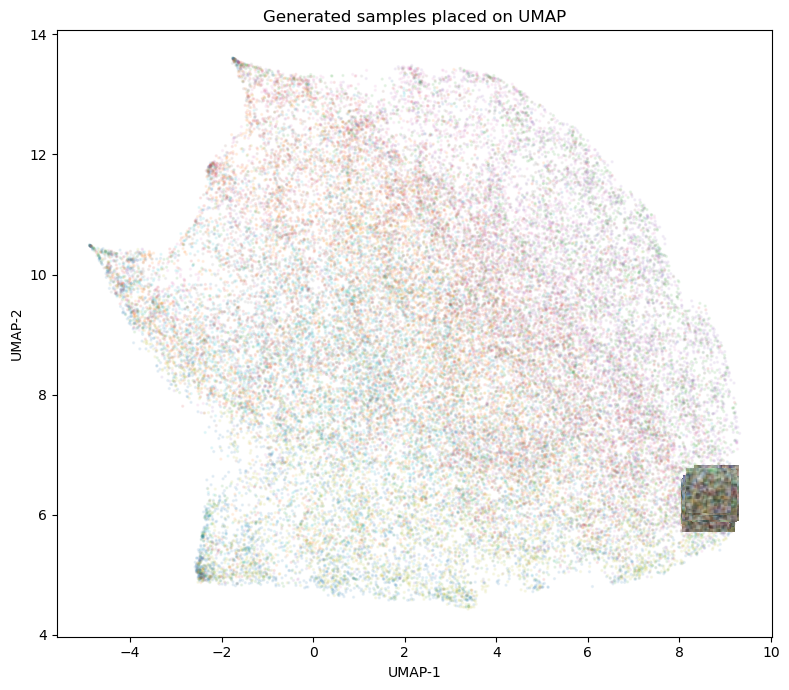

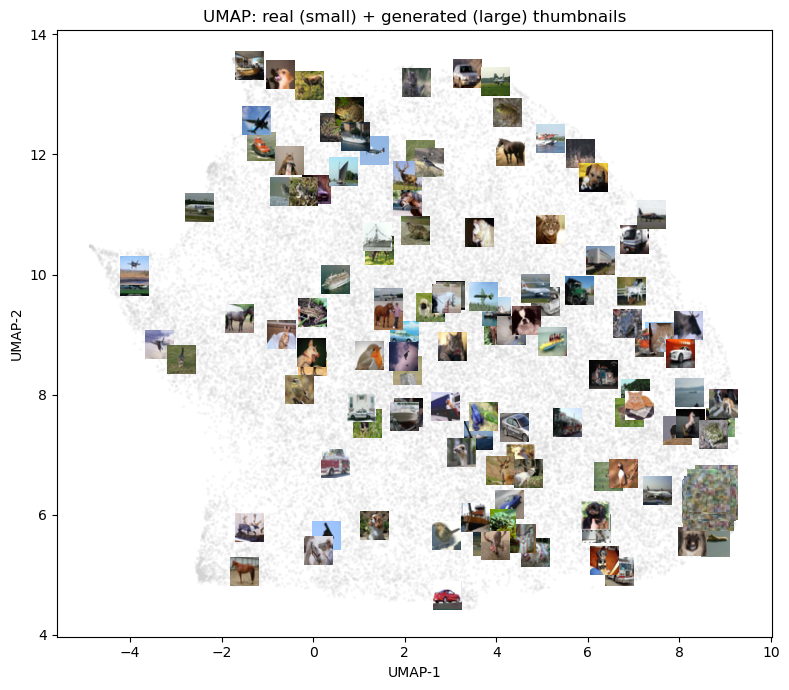

In [15]:
# ===== Step 5: Overlay samples and data points on the same UMAP =====
# Assumes you already have:
#  - model, device
#  - Utr (UMAP 2D of training latents), y_train, CIFAR10_NAMES
#  - umap2d (fitted on train latents), scaler (fitted on Z_train)
#  - trainloader (to fetch a few real images)
#  - mu_lat, std_lat from Step 4 (estimated latent Gaussian for ConvAE)
#
# This will:
#   (A) overlay a small subset of *real* training images as thumbnails
#   (B) generate new samples, project them through encoder -> UMAP, and overlay them too

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def to_vis(x):
    # x in [-1, 1] -> [0,1] for display
    return (x.clamp(-1, 1) + 1) / 2

def imscatter(xs, ys, imgs, zoom=0.9, ax=None):
    """Place small image thumbnails at (xs, ys). imgs: (N, 3, H, W) or (N, 1, H, W)."""
    ax = ax or plt.gca()
    artists = []
    for (x0, y0), imt in zip(zip(xs, ys), imgs):
        im = to_vis(imt).detach().cpu()
        if im.shape[0] == 1:
            im = im.squeeze(0)  # (H, W)
        else:
            im = im.permute(1, 2, 0)  # (H, W, 3)
        oi = OffsetImage(im.numpy(), zoom=zoom, cmap="gray")
        ab = AnnotationBbox(oi, (float(x0), float(y0)), frameon=False)
        artists.append(ax.add_artist(ab))
    return artists

# ---------- (A) Overlay a small subset of REAL training images ----------
np.random.seed(0)
subset_n = 120   # thumbnails to avoid clutter
idx = np.random.choice(len(Utr), size=min(subset_n, len(Utr)), replace=False)

# fetch those images from the dataset
train_ds = trainloader.dataset
real_imgs = torch.stack([train_ds[i][0] for i in idx], 0)           # (N, 3, 32, 32)
U_real = Utr[idx]
y_real = y_train[idx]

plt.figure(figsize=(8, 7))
# faint background of all points for context
plt.scatter(Utr[:, 0], Utr[:, 1], c=y_train, s=2, alpha=0.08, cmap="tab10")
# overlay thumbnails for a small subset
imscatter(U_real[:, 0], U_real[:, 1], real_imgs, zoom=0.75)
plt.title("UMAP with real-image thumbnails (subset)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout(); plt.show()

# ---------- (B) Overlay GENERATED samples on the same UMAP ----------
# Generate a small batch using the estimated latent Gaussian from Step 4
num_gen = 25
temperature = 1.0
with torch.inference_mode():
    eps = torch.randn(num_gen, *mu_lat.shape)
    z_samp = mu_lat.unsqueeze(0) + temperature * std_lat.unsqueeze(0) * eps
    x_gen = model.decoder(z_samp.to(device)).cpu()                  # (B, 3, 32, 32)

    # Project generated images back through the encoder to get their latent vectors
    z_enc = model.encoder(x_gen.to(device))                         # (B, 128, 8, 8)
    z_vec = F.adaptive_avg_pool2d(z_enc, (1, 1)).flatten(1).cpu().numpy()  # (B, 128)

# Scale with the same scaler and map to 2D with the trained UMAP
Z_gen_scaled = scaler.transform(z_vec)
U_gen = umap2d.transform(Z_gen_scaled)

plt.figure(figsize=(8, 7))
# background: training points lightly colored
plt.scatter(Utr[:, 0], Utr[:, 1], c=y_train, s=2, alpha=0.08, cmap="tab10", label="Train (all)")
# overlay generated samples as thumbnails
imscatter(U_gen[:, 0], U_gen[:, 1], x_gen, zoom=1.0)
plt.title("Generated samples placed on UMAP")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout(); plt.show()

# ---------- (Optional) Mixed overlay: a few real + generated on same canvas ----------
plt.figure(figsize=(8, 7))
plt.scatter(Utr[:, 0], Utr[:, 1], c="lightgray", s=2, alpha=0.12, label="Train (all)")
imscatter(U_real[:, 0], U_real[:, 1], real_imgs, zoom=0.65)        # real thumbnails
imscatter(U_gen[:, 0], U_gen[:, 1], x_gen, zoom=0.95)               # generated thumbnails (slightly larger)
plt.title("UMAP: real (small) + generated (large) thumbnails")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout(); plt.show()


# Feature extraction 
From latent space

# Train classifier/regressor 
Using the latent space representation of the samples

/storage/homefs/ae04q066/.conda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LogReg] Test accuracy on latent features: 0.4391
              precision    recall  f1-score   support

           0      0.477     0.472     0.474      1000
           1      0.501     0.504     0.502      1000
           2      0.347     0.296     0.320      1000
           3      0.342     0.284     0.310      1000
           4      0.404     0.361     0.381      1000
           5      0.388     0.372     0.380      1000
           6      0.446     0.543     0.490      1000
           7      0.446     0.454     0.450      1000
           8      0.506     0.625     0.559      1000
           9      0.480     0.480     0.480      1000

    accuracy                          0.439     10000
   macro avg      0.434     0.439     0.435     10000
weighted avg      0.434     0.439     0.435     10000



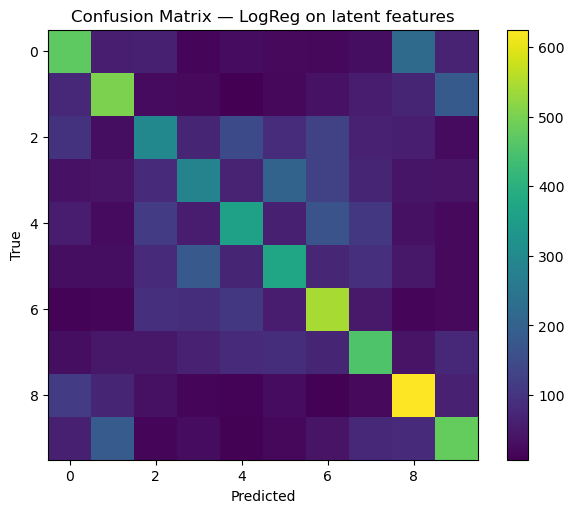

[LinearSVM] Test accuracy on latent features: 0.4448
[Ridge] Brightness regression — R^2: -0.006 | MAE: 0.0957


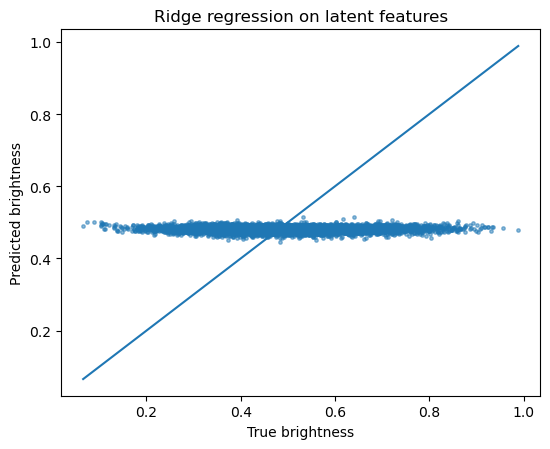

/storage/homefs/ae04q066/.conda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [16]:
# ===== Step 6: Train a classifier / regressor on latent features =====
# Assumes you already have from Step 2:
#   Z_train, y_train, Z_test, y_test           # latent features (e.g., GAP over (128,8,8))
#   scaler, Ztr, Zte                           # StandardScaler fitted on train (Ztr=scaled train, Zte=scaled test)

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch

# ---------- A) Classification on latent features (Logistic Regression) ----------
clf = LogisticRegression(
    max_iter=4000,
    multi_class="multinomial",
    solver="saga",        # robust on many samples / features
    penalty="l2",
    C=1.0,
    n_jobs=-1,
    verbose=0
)
clf.fit(Ztr, y_train)

y_pred = clf.predict(Zte)
acc = accuracy_score(y_test, y_pred)
print(f"[LogReg] Test accuracy on latent features: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix (optional)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6.4, 5.2))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — LogReg on latent features")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar(); plt.tight_layout()
plt.show()

# ---------- (Optional) Strong linear baseline: Linear SVM ----------
from sklearn.svm import LinearSVC
svm = LinearSVC(C=1.0, dual="auto")
svm.fit(Ztr, y_train)
svm_pred = svm.predict(Zte)
svm_acc = accuracy_score(y_test, svm_pred)
print(f"[LinearSVM] Test accuracy on latent features: {svm_acc:.4f}")

# ---------- B) Regression on latent features (example: image brightness) ----------
# We'll create a simple continuous target: average luminance of each image.
# Compute brightness for train/test in the SAME order used to build Z_train/Z_test.

def collect_brightness(dataloader):
    vals = []
    for xb, _ in dataloader:
        # xb is in [-1, 1]; map to [0,1]
        x01 = (xb.clamp(-1, 1) + 1) / 2.0
        # luminance (Rec.709): 0.2126 R + 0.7152 G + 0.0722 B
        y_lum = (0.2126 * x01[:,0] + 0.7152 * x01[:,1] + 0.0722 * x01[:,2]).mean(dim=(1,2))
        vals.append(y_lum.numpy())
    return np.concatenate(vals, axis=0)

y_bright_train = collect_brightness(trainloader)  # length == len(Z_train)
y_bright_test  = collect_brightness(testloader)   # length == len(Z_test)

regr = Ridge(alpha=1.0)
regr.fit(Ztr, y_bright_train)
pred_bright = regr.predict(Zte)

# R^2 and simple scatter
from sklearn.metrics import r2_score, mean_absolute_error
r2  = r2_score(y_bright_test, pred_bright)
mae = mean_absolute_error(y_bright_test, pred_bright)
print(f"[Ridge] Brightness regression — R^2: {r2:.3f} | MAE: {mae:.4f}")

plt.figure(figsize=(5.6, 4.6))
plt.scatter(y_bright_test, pred_bright, s=6, alpha=0.5)
mn, mx = y_bright_test.min(), y_bright_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True brightness"); plt.ylabel("Predicted brightness")
plt.title("Ridge regression on latent features")
plt.tight_layout(); plt.show()

# ---------- C) (Optional) Quick sanity comparison vs raw pixels ----------
# How much do latents help vs using raw 3*32*32 pixels?
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
Xtr_pixels = []
Xte_pixels = []

for xb, _ in trainloader:
    Xtr_pixels.append(xb.view(xb.size(0), -1).numpy())
for xb, _ in testloader:
    Xte_pixels.append(xb.view(xb.size(0), -1).numpy())

Xtr_pixels = np.concatenate(Xtr_pixels, 0)
Xte_pixels = np.concatenate(Xte_pixels, 0)

pix_clf = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=2000, multi_class="multinomial", solver="saga"))
pix_clf.fit(Xtr_pixels, y_train)
pix_acc = accuracy_score(y_test, pix_clf.predict(Xte_pixels))
print(f"[Pixel baseline] LogReg on raw pixels — Test accuracy: {pix_acc:.4f}")

# A higher accuracy with latent features vs. pixels indicates the autoencoder learned useful structure.
